In [1]:
import h5py
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
%matplotlib inline 
import seaborn


    
    
#torch.cuda.empty_cache()

pathOfmodel="/home/mena/G2BigGPU/128/5T30AllDataSet_Last"

def show_tensor_images(epoch,index,image_tensor, num_images=13, size=(1, 28, 28),show=True,RealOrFake=True,ep=1,cond=False):
    sample_dir=pathOfmodel
    if cond:
        fake_fname = 'condition-images-epoch{0:0=4d}_step{1:0=4d}.png'.format(epoch,index)
    else:
        if(RealOrFake):
            fake_fname = 'Real-images-epoch{0:0=4d}_step{1:0=4d}.png'.format(epoch,index)
        else:
            fake_fname = 'Fake-images-epoch{0:0=4d}_step{1:0=4d}.png'.format(epoch,index)
    fig, axes = plt.subplots(nrows=3,ncols=3, figsize=(25,25))
    im=[1,2,3,4,5,6,7,8,9,10]
    index=0
    for i in range(3):
        for j in range(3):
            im[index] = axes[i,j].matshow(image_tensor[index].to("cpu").view(image_size,image_size).detach().numpy(),cmap="rocket")
            fig.colorbar(im[index], ax=axes[i,j])
            index+=1
    fig.savefig(os.path.join(sample_dir, fake_fname))
    print("")
    plt.close()
    print('Saving', fake_fname)    

In [2]:
#Natural
data_path="/home/mena/dataSets/dataset.hdf5"
image_size=128
batch_size=128
with h5py.File(data_path, "r") as data_file:
    x = data_file[f"train_{image_size}"][:771*128]#=89600 from #98560
data_len = len(x)
print(data_len)#####batch ##inputChannel
dataloader = DataLoader(x, batch_size=batch_size, shuffle=True)#, num_workers=workers)

98688


In [3]:
batch_size

128

In [4]:
def conv_block(in_channels, out_channels, pool=False):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
        nn.BatchNorm2d(out_channels), 
        nn.LeakyReLU(0.2, inplace=True)]
        if pool: layers.append(nn.MaxPool2d(2))
        return nn.Sequential(*layers)
    
class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels,stride=2, padding=1,droup=False):
        super(Upsample, self).__init__()
        self.modules = []
        self.modules.append(nn.ConvTranspose2d(Input_Channels, Output_Channels, kernel_size=4, stride=stride, padding=padding, bias=False))
        self.modules.append(nn.BatchNorm2d(Output_Channels))
        if droup:
            self.modules.append(nn.Dropout(0.5))
        self.modules.append(nn.LeakyReLU(0.2, inplace=True))
        self.model=nn.Sequential(*self.modules)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x

    

In [5]:

class Generator128(nn.Module):
	def __init__(self, ngpu):
		super(Generator128, self).__init__()
		self.conv1=nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.LeakyReLU(0.2, inplace=True),
                                )#64*64

		self.conv2=nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(128),#16*16
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#32*32
		self.conv3=nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
                                nn.BatchNorm2d(256),
                                nn.LeakyReLU(0.2, inplace=True),
                                nn.Dropout(0.1)
                                )#16
        
		self.conv4=nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#8
		self.conv4_=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(0.2, inplace=True),
                                    nn.Dropout(0.1)
                                )#4*4
                
        
		self.conv5=nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=1, padding=0, bias=False)
                                )#1
        
		self.convT1 =Upsample(512,512,droup=True, padding=0)4*4
		self.convT2_ = Upsample(512*2,512,droup=True)8*8
		self.convT2 = Upsample(512*2,256,droup=True)1*16*16
        
		self.resT1 = nn.Sequential(conv_block(256*2, 256*2), conv_block(256*2, 256*2))
        
		self.convT3 =Upsample(256*2,128)1*32*32
		self.convT4 =Upsample(128*2,64)1*64*64
		self.resT2 = nn.Sequential(conv_block(64*2, 64*2), conv_block(64*2, 64*2))
		self.convT5=nn.Sequential(  nn.ConvTranspose2d(64*2, 1, kernel_size=4, stride=2, padding=1, bias=False))



	def forward(self, input):
		out1 = self.conv1(input)
		out2 = self.conv2(out1)
		out3 = self.conv3(out2)
		out4 = self.conv4(out3)
		out4_ = self.conv4_(out4)
		out5 = self.conv5(out4_)  
       
		outT1 = self.convT1(out5,out4_)
		outT2_ = self.convT2_(outT1,out4)
		outT2 = self.convT2(outT2_,out3)
		outT3 = self.resT1(outT2) + outT2#############
		outT4 = self.convT3(outT3,out2)
		outT5 = self.convT4(outT4,out1)
		outT6 = self.resT2(outT5) + outT5###########
		outT7 = self.convT5(outT6)
		return outT7

In [6]:

def test():
    x=torch.randn((batch_size,1,image_size,image_size))
    model2=Generator128(1)
    print(Generator128)
    preds=model2(x)
    print(preds.shape)
test()

<class '__main__.Generator128'>
torch.Size([128, 1, 128, 128])


In [8]:
class Discriminator128(nn.Module):
    def __init__(self):
        super(Discriminator128, self).__init__()
        #128
        self.conv1D=nn.Sequential(nn.Conv2d(2, 64, 4, 2, 1, bias=False),
                                 nn.LeakyReLU(0.2, inplace=True),
                                )
        #64
        self.conv2D=nn.Sequential( nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                                  nn.BatchNorm2d(128),
                                 nn.LeakyReLU(0.2, inplace=True),
                                )
        #32
        self.conv3D=nn.Sequential(nn.Conv2d(128, 256, 3, 1, 1, bias=False),
                                 nn.BatchNorm2d(256),
                                 nn.LeakyReLU(0.2, inplace=True),
                                )
        #32
        self.conv4D=nn.Sequential(nn.Conv2d(256, 512, 5, 1, 1, bias=False),
                                 nn.BatchNorm2d(512),
                                 nn.LeakyReLU(0.2, inplace=True),
                                )
        #30
        self.conv5D=nn.Sequential(
                                nn.Conv2d(512, 1, 3, 1, 1, bias=False),
                                nn.Sigmoid())
        #patch of 30*30
        
        
    def forward(self, x,y):
        x2 = torch.cat([x, y], axis=1)
        out = self.conv1D(x2)
        out = self.conv2D(out)
        out = self.conv3D(out)
        out = self.conv4D(out)
        out = self.conv5D(out)
        return out    



In [9]:
test_discriminator = Discriminator64()
test_discriminator(
    torch.randn(1, 1, 64, 64), 
    torch.randn(1, 1, 64, 64)
).shape


torch.Size([1, 1, 30, 30])

In [10]:
test_discriminator = Discriminator128()
test_discriminator(
    torch.randn(1, 1, 128, 128), 
    torch.randn(1, 1, 128, 128)
).shape


torch.Size([1, 1, 30, 30])

In [11]:
test_discriminator = Discriminator128()
assert tuple(test_discriminator(
    torch.randn(1, 1, image_size, image_size), 
    torch.randn(1, 1, image_size, image_size)
).shape) == (1, 1, 30, 30)
print("Success!")

Success!


In [12]:
import torch.nn.functional as F
# New parameters
adv_criterion = nn.BCELoss()#BCEWithLogitsLoss() 
recon_criterion = nn.L1Loss() 
lambda_recon = 200

n_epochs = 10
input_dim = 1
real_dim = 1
display_step = 771
lr = 0.0001
target_shape = image_size
device = 'cuda:1'

In [13]:
gen = Generator128(1).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator128().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)


In [14]:
def get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr):
    noiseArr_Comp=(noiseArr*-1)+1
    noiseArr_Comp=noiseArr_Comp.to(device)
    fake = gen(condition)
    disc_fake_hat = disc(fake, condition)
    gen_adv_loss = adv_criterion(disc_fake_hat, torch.ones_like(disc_fake_hat))
    gen_rec_loss = recon_criterion(real, fake)
    gen_loss = gen_adv_loss + lambda_recon * gen_rec_loss + (lambda_recon*10*recon_criterion(noiseArr_Comp*fake,noiseArr_Comp*real))
    return gen_loss



In [16]:
import random

def getNoise():
    noiseArr = torch.ones(size=(batch_size,1,image_size, image_size)).to(dtype=torch.float32)
    for i in range(0,batch_size-2,6):
        ar=[5,10,15,20,25,30]
        random.shuffle(ar) 
        im=np.random.randint(image_size-ar[0])
        noiseArr[i][0][im:im+ar[0],:]=0
        noiseArr[i][0][:,im:im+ar[0]]=0
        im=np.random.randint(image_size-ar[1])
        noiseArr[i+1][0][im:im+ar[1],:]=0
        noiseArr[i+1][0][:,im:im+ar[1]]=0
        im=np.random.randint(image_size-ar[2])
        noiseArr[i+2][0][im:im+ar[2],:]=0
        noiseArr[i+2][0][:,im:im+ar[2]]=0
        im=np.random.randint(image_size-ar[3])
        noiseArr[i+3][0][im:im+ar[3],:]=0
        noiseArr[i+3][0][:,im:im+ar[3]]=0
        im=np.random.randint(image_size-ar[4])
        noiseArr[i+4][0][im:im+ar[4],:]=0
        noiseArr[i+4][0][:,im:im+ar[4]]=0
        im=np.random.randint(image_size-ar[5])
        noiseArr[i+5][0][im:im+ar[5],:]=0
        noiseArr[i+5][0][:,im:im+ar[5]]=0
    im=np.random.randint(image_size-20)
    noiseArr[126][0][im:im+30,:]=0
    noiseArr[126][0][:,im:im+30]=0
    im=np.random.randint(image_size-25)
    noiseArr[127][0][im:im+25,:]=0
    noiseArr[127][0][:,im:im+25]=0
    random.shuffle(ar) 
    return noiseArr
    

In [18]:
image_size
display_step=771*5

In [19]:
n_epochs=100

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 4: Step 3855: Generator (U-Net) loss: 4062.603980157162, Discriminator loss: 0.05338568421906331

Saving Fake-images-epoch0004_step3855.png

Saving Real-images-epoch0004_step3855.png

Saving condition-images-epoch0004_step3855.png


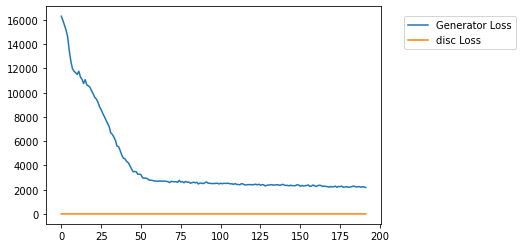

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 9: Step 7710: Generator (U-Net) loss: 2072.1519210795614, Discriminator loss: 0.01834543009532312

Saving Fake-images-epoch0009_step7710.png

Saving Real-images-epoch0009_step7710.png

Saving condition-images-epoch0009_step7710.png


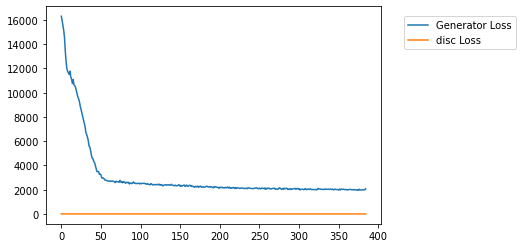

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 14: Step 11565: Generator (U-Net) loss: 1934.7707737389578, Discriminator loss: 0.007639597261077053

Saving Fake-images-epoch0014_step11565.png

Saving Real-images-epoch0014_step11565.png

Saving condition-images-epoch0014_step11565.png


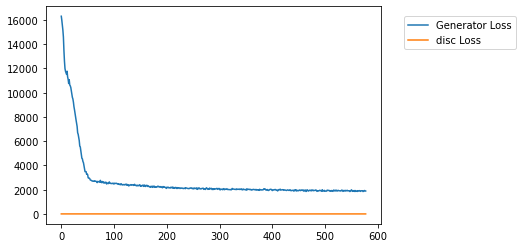

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 19: Step 15420: Generator (U-Net) loss: 1837.3649478026668, Discriminator loss: 0.008826992720980502

Saving Fake-images-epoch0019_step15420.png

Saving Real-images-epoch0019_step15420.png

Saving condition-images-epoch0019_step15420.png


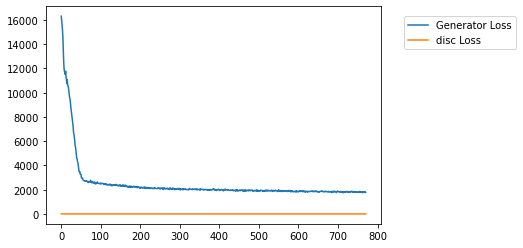

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 24: Step 19275: Generator (U-Net) loss: 1772.9336911529265, Discriminator loss: 0.005252852798589049

Saving Fake-images-epoch0024_step19275.png

Saving Real-images-epoch0024_step19275.png

Saving condition-images-epoch0024_step19275.png


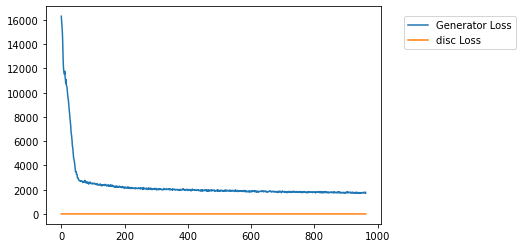

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 29: Step 23130: Generator (U-Net) loss: 1713.7433792925642, Discriminator loss: 0.01349620047844163

Saving Fake-images-epoch0029_step23130.png

Saving Real-images-epoch0029_step23130.png

Saving condition-images-epoch0029_step23130.png


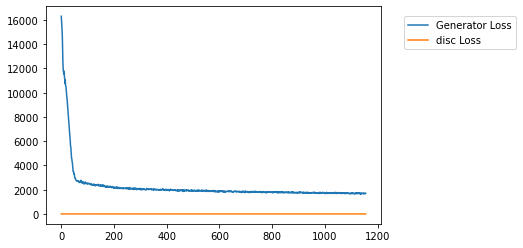

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 34: Step 26985: Generator (U-Net) loss: 1665.7144766524282, Discriminator loss: 0.007701923832845914

Saving Fake-images-epoch0034_step26985.png

Saving Real-images-epoch0034_step26985.png

Saving condition-images-epoch0034_step26985.png


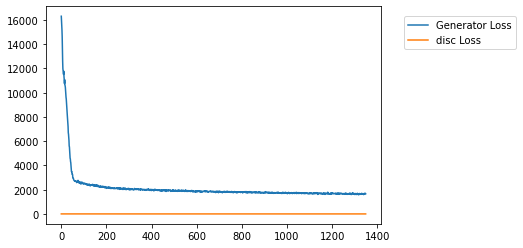

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 39: Step 30840: Generator (U-Net) loss: 1624.5666893707937, Discriminator loss: 0.005949111622990178

Saving Fake-images-epoch0039_step30840.png

Saving Real-images-epoch0039_step30840.png

Saving condition-images-epoch0039_step30840.png


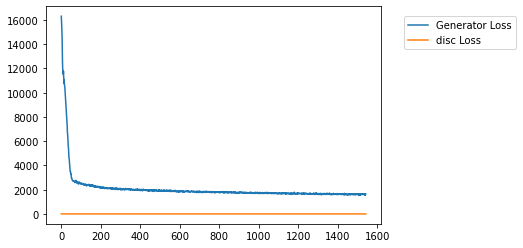

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 44: Step 34695: Generator (U-Net) loss: 1588.2932050692561, Discriminator loss: 7.023594189872455e-05

Saving Fake-images-epoch0044_step34695.png

Saving Real-images-epoch0044_step34695.png

Saving condition-images-epoch0044_step34695.png


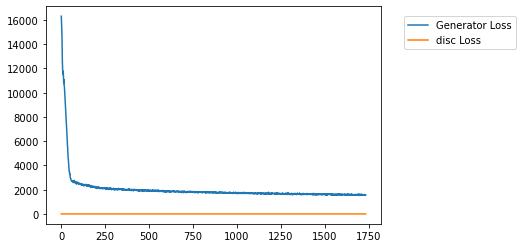

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 49: Step 38550: Generator (U-Net) loss: 1554.6868532648382, Discriminator loss: 0.009589254453015677

Saving Fake-images-epoch0049_step38550.png

Saving Real-images-epoch0049_step38550.png

Saving condition-images-epoch0049_step38550.png


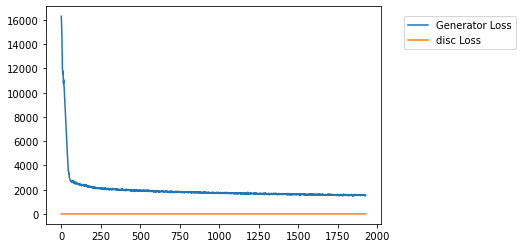

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 54: Step 42405: Generator (U-Net) loss: 1526.1161466883054, Discriminator loss: 4.943816136815768e-05

Saving Fake-images-epoch0054_step42405.png

Saving Real-images-epoch0054_step42405.png

Saving condition-images-epoch0054_step42405.png


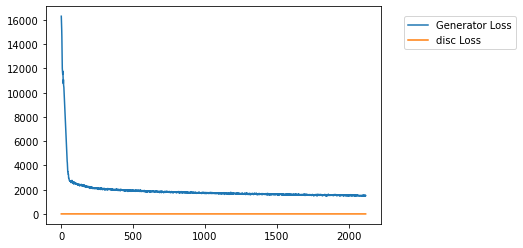

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 59: Step 46260: Generator (U-Net) loss: 1499.8607519404588, Discriminator loss: 0.002569340084694009

Saving Fake-images-epoch0059_step46260.png

Saving Real-images-epoch0059_step46260.png

Saving condition-images-epoch0059_step46260.png


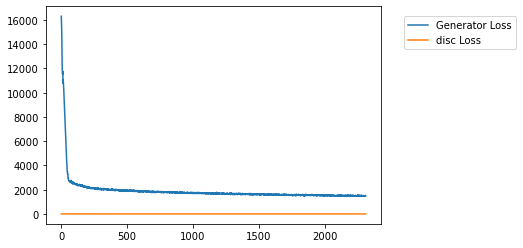

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 64: Step 50115: Generator (U-Net) loss: 1476.8609859164762, Discriminator loss: 6.1002341954244505e-05

Saving Fake-images-epoch0064_step50115.png

Saving Real-images-epoch0064_step50115.png

Saving condition-images-epoch0064_step50115.png


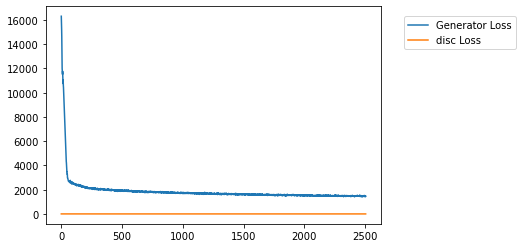

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 69: Step 53970: Generator (U-Net) loss: 1453.5575836537932, Discriminator loss: 0.004244731282739327

Saving Fake-images-epoch0069_step53970.png

Saving Real-images-epoch0069_step53970.png

Saving condition-images-epoch0069_step53970.png


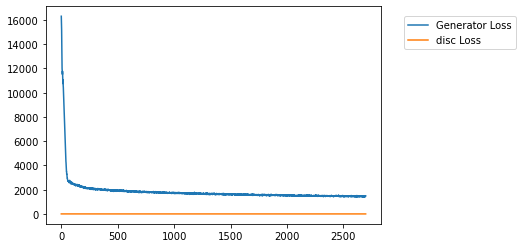

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 74: Step 57825: Generator (U-Net) loss: 1432.6966392823851, Discriminator loss: 0.0011549901626117355

Saving Fake-images-epoch0074_step57825.png

Saving Real-images-epoch0074_step57825.png

Saving condition-images-epoch0074_step57825.png


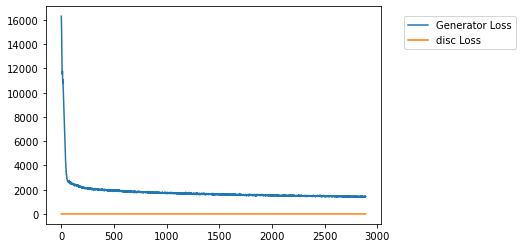

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 79: Step 61680: Generator (U-Net) loss: 1413.2065304925636, Discriminator loss: 0.0038050660248602915

Saving Fake-images-epoch0079_step61680.png

Saving Real-images-epoch0079_step61680.png

Saving condition-images-epoch0079_step61680.png


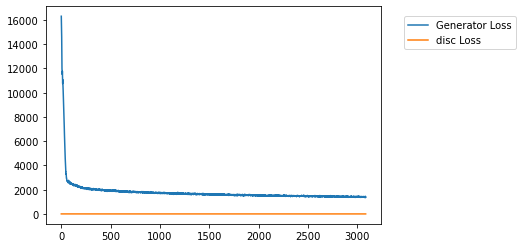

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 84: Step 65535: Generator (U-Net) loss: 1397.5282072985005, Discriminator loss: 9.407956565359541e-05

Saving Fake-images-epoch0084_step65535.png

Saving Real-images-epoch0084_step65535.png

Saving condition-images-epoch0084_step65535.png


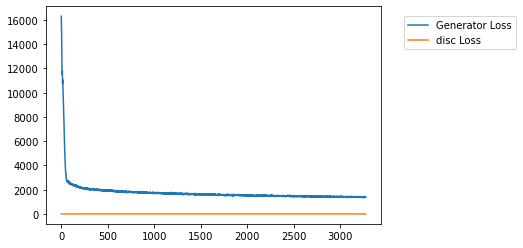

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 89: Step 69390: Generator (U-Net) loss: 1383.6535109385093, Discriminator loss: 9.484954785909929e-06

Saving Fake-images-epoch0089_step69390.png

Saving Real-images-epoch0089_step69390.png

Saving condition-images-epoch0089_step69390.png


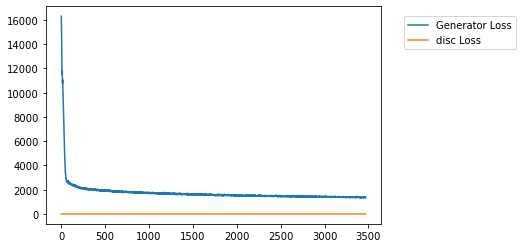

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 94: Step 73245: Generator (U-Net) loss: 1368.4213841538458, Discriminator loss: 0.008371063572157734

Saving Fake-images-epoch0094_step73245.png

Saving Real-images-epoch0094_step73245.png

Saving condition-images-epoch0094_step73245.png


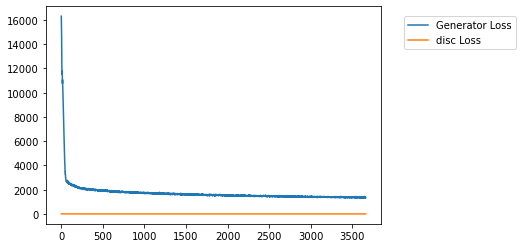

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 99: Step 77100: Generator (U-Net) loss: 1356.3413670165096, Discriminator loss: 2.4532962578456723e-05

Saving Fake-images-epoch0099_step77100.png

Saving Real-images-epoch0099_step77100.png

Saving condition-images-epoch0099_step77100.png


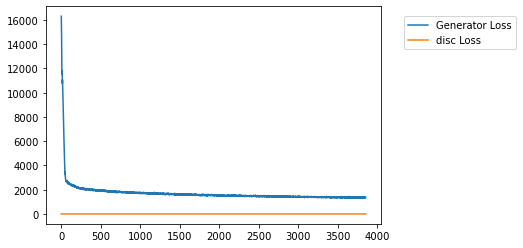

In [20]:
from skimage import color
import numpy as np
import seaborn as sns
import numpy as np
import random

disc_losses=[]
generator_losses=[]
step_bins=20

save_model=True    
#def train(save_model=True):
mean_generator_loss = 0
mean_discriminator_loss = 0
cur_step = 0
step_bins=20
image_width = image_size

for epoch in tqdm(range(n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
                

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 104: Step 80955: Generator (U-Net) loss: 1342.2986845221847, Discriminator loss: 0.0023275488781645003

Saving Fake-images-epoch0104_step80955.png

Saving Real-images-epoch0104_step80955.png

Saving condition-images-epoch0104_step80955.png


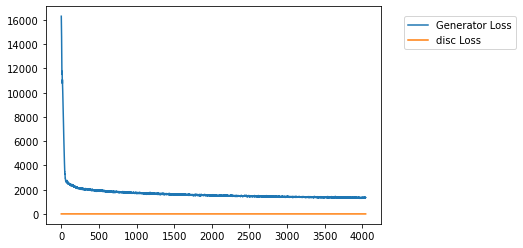

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 109: Step 84810: Generator (U-Net) loss: 1330.4871493367984, Discriminator loss: 0.004395414041281449

Saving Fake-images-epoch0109_step84810.png

Saving Real-images-epoch0109_step84810.png

Saving condition-images-epoch0109_step84810.png


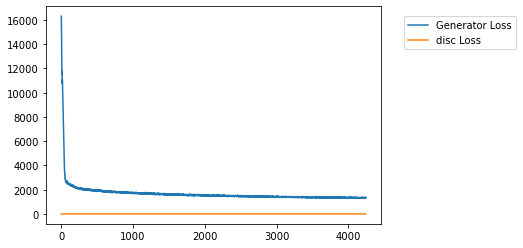

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 114: Step 88665: Generator (U-Net) loss: 1316.8347105587818, Discriminator loss: 0.005059970236908548

Saving Fake-images-epoch0114_step88665.png

Saving Real-images-epoch0114_step88665.png

Saving condition-images-epoch0114_step88665.png


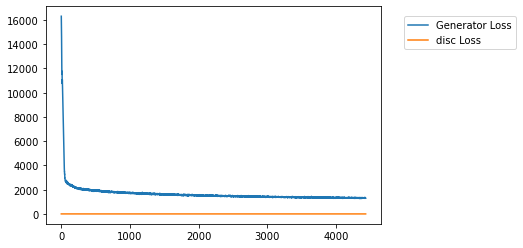

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 119: Step 92520: Generator (U-Net) loss: 1306.2448293168884, Discriminator loss: 3.565895741110517e-05

Saving Fake-images-epoch0119_step92520.png

Saving Real-images-epoch0119_step92520.png

Saving condition-images-epoch0119_step92520.png


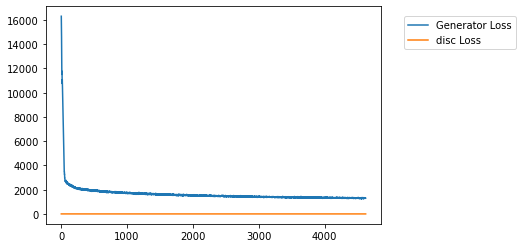

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 124: Step 96375: Generator (U-Net) loss: 1297.5969329477714, Discriminator loss: 0.0030891658092952567

Saving Fake-images-epoch0124_step96375.png

Saving Real-images-epoch0124_step96375.png

Saving condition-images-epoch0124_step96375.png


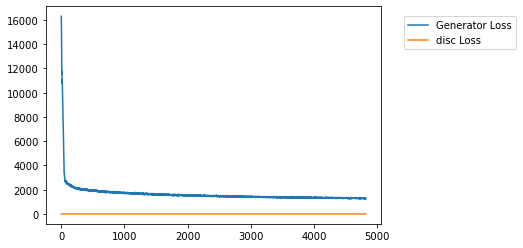

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 129: Step 100230: Generator (U-Net) loss: 1288.0442357163472, Discriminator loss: 2.7117341381319692e-05

Saving Fake-images-epoch0129_step100230.png

Saving Real-images-epoch0129_step100230.png

Saving condition-images-epoch0129_step100230.png


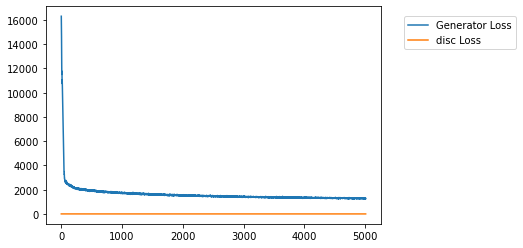

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 134: Step 104085: Generator (U-Net) loss: 1279.9176569403096, Discriminator loss: 0.004120063824245519

Saving Fake-images-epoch0134_step104085.png

Saving Real-images-epoch0134_step104085.png

Saving condition-images-epoch0134_step104085.png


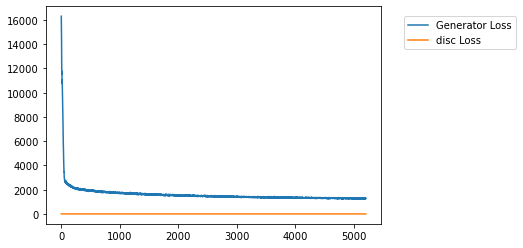

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 139: Step 107940: Generator (U-Net) loss: 1267.969857530801, Discriminator loss: 0.00020471786424393598

Saving Fake-images-epoch0139_step107940.png

Saving Real-images-epoch0139_step107940.png

Saving condition-images-epoch0139_step107940.png


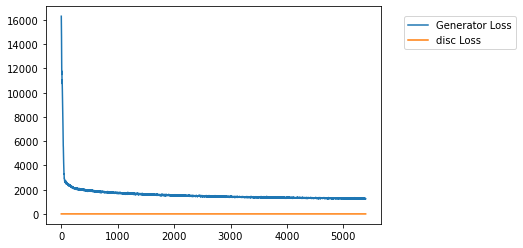

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 144: Step 111795: Generator (U-Net) loss: 1260.6715351505509, Discriminator loss: 0.003132850574733093

Saving Fake-images-epoch0144_step111795.png

Saving Real-images-epoch0144_step111795.png

Saving condition-images-epoch0144_step111795.png


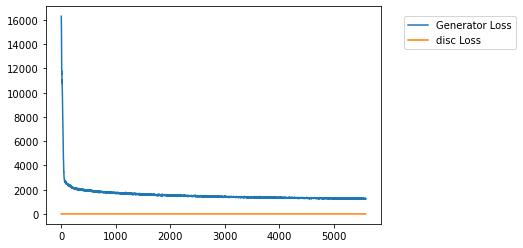

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 149: Step 115650: Generator (U-Net) loss: 1251.0803511128518, Discriminator loss: 0.005971841575651515

Saving Fake-images-epoch0149_step115650.png

Saving Real-images-epoch0149_step115650.png

Saving condition-images-epoch0149_step115650.png


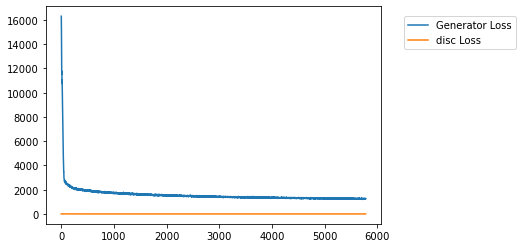

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 154: Step 119505: Generator (U-Net) loss: 1243.5378880442643, Discriminator loss: 0.0027043898769053202

Saving Fake-images-epoch0154_step119505.png

Saving Real-images-epoch0154_step119505.png

Saving condition-images-epoch0154_step119505.png


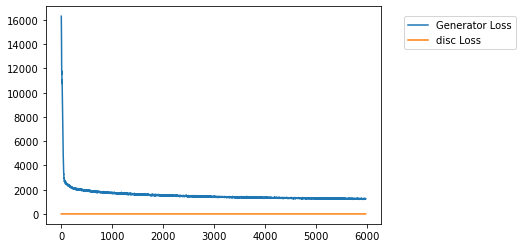

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 159: Step 123360: Generator (U-Net) loss: 1235.3711644431196, Discriminator loss: 1.1075723662365642e-05

Saving Fake-images-epoch0159_step123360.png

Saving Real-images-epoch0159_step123360.png

Saving condition-images-epoch0159_step123360.png


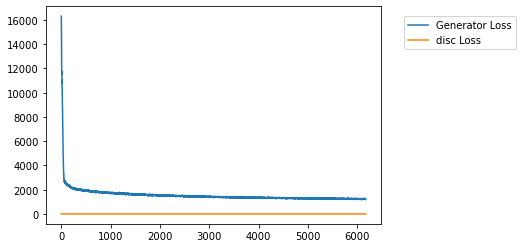

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 164: Step 127215: Generator (U-Net) loss: 1227.4424030150574, Discriminator loss: 0.003628336067673513

Saving Fake-images-epoch0164_step127215.png

Saving Real-images-epoch0164_step127215.png

Saving condition-images-epoch0164_step127215.png


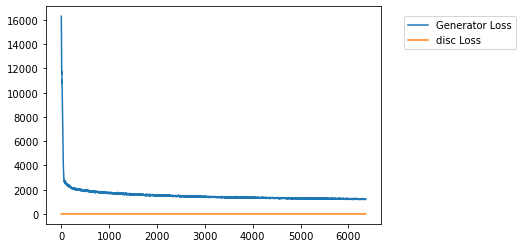

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 169: Step 131070: Generator (U-Net) loss: 1224.5847668757872, Discriminator loss: 2.1405685349257857e-05

Saving Fake-images-epoch0169_step131070.png

Saving Real-images-epoch0169_step131070.png

Saving condition-images-epoch0169_step131070.png


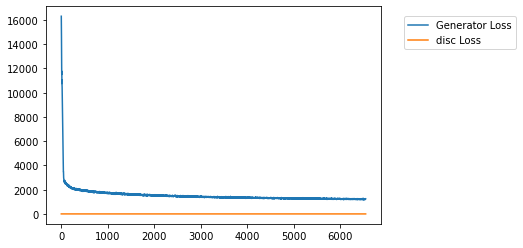

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 174: Step 134925: Generator (U-Net) loss: 1215.754944686793, Discriminator loss: 0.0035302671067618764

Saving Fake-images-epoch0174_step134925.png

Saving Real-images-epoch0174_step134925.png

Saving condition-images-epoch0174_step134925.png


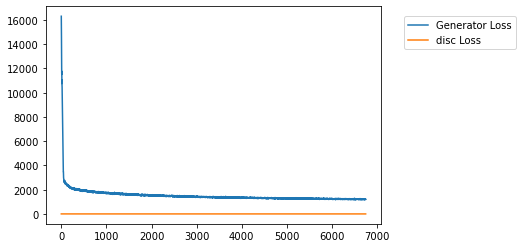

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 179: Step 138780: Generator (U-Net) loss: 1213.021780494463, Discriminator loss: 5.1540549759598316e-05

Saving Fake-images-epoch0179_step138780.png

Saving Real-images-epoch0179_step138780.png

Saving condition-images-epoch0179_step138780.png


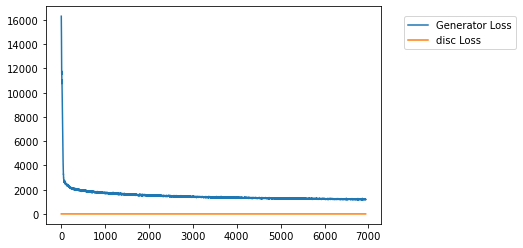

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 184: Step 142635: Generator (U-Net) loss: 1204.6424388761768, Discriminator loss: 0.004393175823079607

Saving Fake-images-epoch0184_step142635.png

Saving Real-images-epoch0184_step142635.png

Saving condition-images-epoch0184_step142635.png


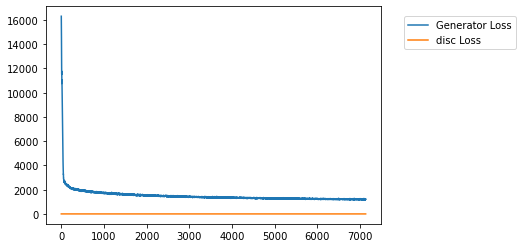

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 189: Step 146490: Generator (U-Net) loss: 1195.0505769286733, Discriminator loss: 0.004979901213637122

Saving Fake-images-epoch0189_step146490.png

Saving Real-images-epoch0189_step146490.png

Saving condition-images-epoch0189_step146490.png


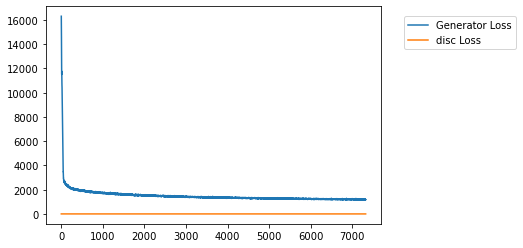

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 194: Step 150345: Generator (U-Net) loss: 1192.1484119301467, Discriminator loss: 0.00246981183005751

Saving Fake-images-epoch0194_step150345.png

Saving Real-images-epoch0194_step150345.png

Saving condition-images-epoch0194_step150345.png


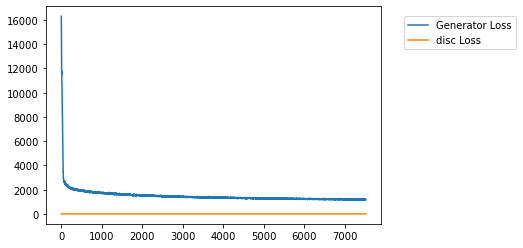

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 199: Step 154200: Generator (U-Net) loss: 1187.5635907956103, Discriminator loss: 0.00039786953189836977

Saving Fake-images-epoch0199_step154200.png

Saving Real-images-epoch0199_step154200.png

Saving condition-images-epoch0199_step154200.png


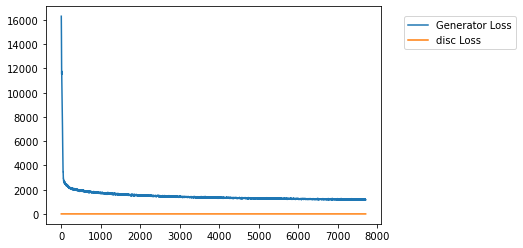

In [22]:
n_epochs=200
for epoch in tqdm(range(100,n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
                

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 204: Step 158055: Generator (U-Net) loss: 1179.5706265421063, Discriminator loss: 6.366330637819034e-06

Saving Fake-images-epoch0204_step158055.png

Saving Real-images-epoch0204_step158055.png

Saving condition-images-epoch0204_step158055.png


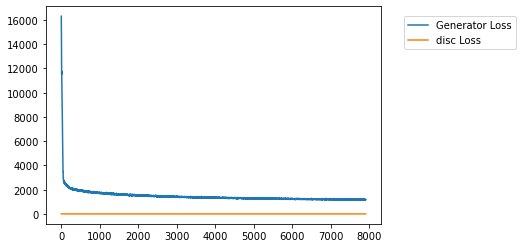

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 209: Step 161910: Generator (U-Net) loss: 1175.8473170655266, Discriminator loss: 0.004169074237652142

Saving Fake-images-epoch0209_step161910.png

Saving Real-images-epoch0209_step161910.png

Saving condition-images-epoch0209_step161910.png


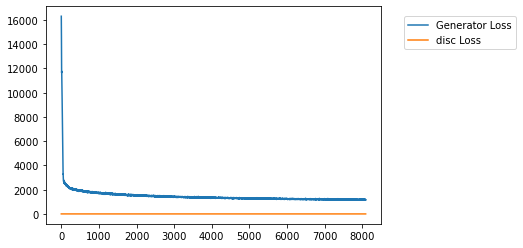

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 214: Step 165765: Generator (U-Net) loss: 1171.7651543880743, Discriminator loss: 0.0019516634375118963

Saving Fake-images-epoch0214_step165765.png

Saving Real-images-epoch0214_step165765.png

Saving condition-images-epoch0214_step165765.png


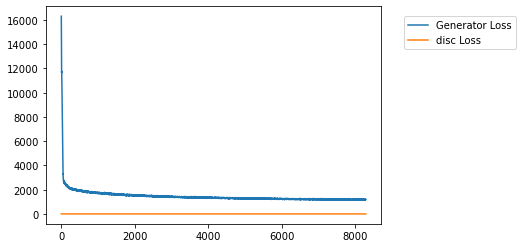

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 219: Step 169620: Generator (U-Net) loss: 1165.8821150526176, Discriminator loss: 1.4038463068257488e-05

Saving Fake-images-epoch0219_step169620.png

Saving Real-images-epoch0219_step169620.png

Saving condition-images-epoch0219_step169620.png


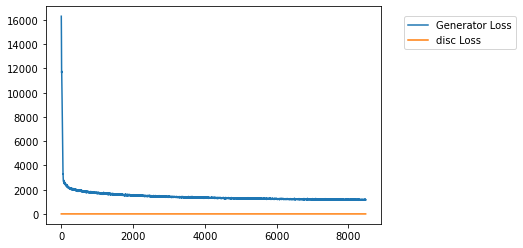

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 224: Step 173475: Generator (U-Net) loss: 1164.5843909593914, Discriminator loss: 3.8446481882625975e-06

Saving Fake-images-epoch0224_step173475.png

Saving Real-images-epoch0224_step173475.png

Saving condition-images-epoch0224_step173475.png


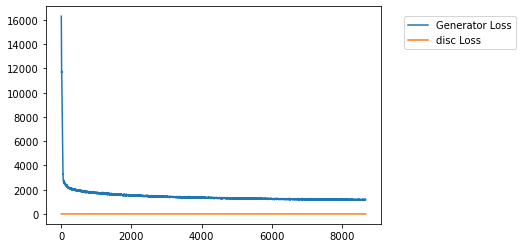

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 229: Step 177330: Generator (U-Net) loss: 1157.7958633838439, Discriminator loss: 0.002128449439852889

Saving Fake-images-epoch0229_step177330.png

Saving Real-images-epoch0229_step177330.png

Saving condition-images-epoch0229_step177330.png


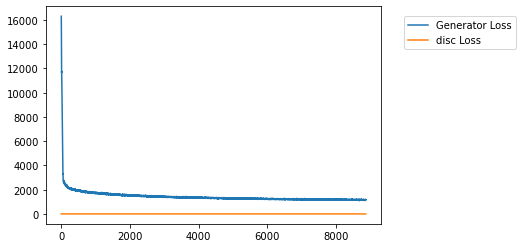

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 234: Step 181185: Generator (U-Net) loss: 1152.9479704346068, Discriminator loss: 1.4634691869522185e-05

Saving Fake-images-epoch0234_step181185.png

Saving Real-images-epoch0234_step181185.png

Saving condition-images-epoch0234_step181185.png


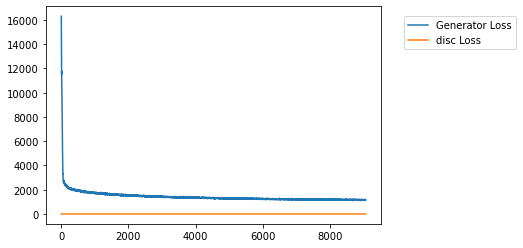

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 239: Step 185040: Generator (U-Net) loss: 1147.7035662897229, Discriminator loss: 1.8048144365674137e-06

Saving Fake-images-epoch0239_step185040.png

Saving Real-images-epoch0239_step185040.png

Saving condition-images-epoch0239_step185040.png


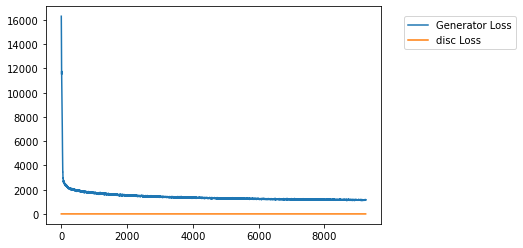

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 244: Step 188895: Generator (U-Net) loss: 1141.596790025761, Discriminator loss: 0.0036630614136080966

Saving Fake-images-epoch0244_step188895.png

Saving Real-images-epoch0244_step188895.png

Saving condition-images-epoch0244_step188895.png


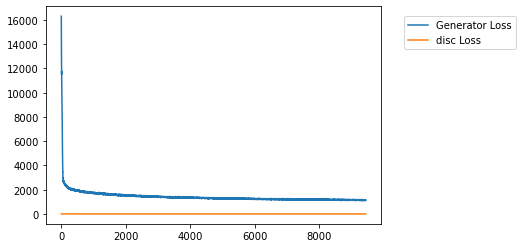

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 249: Step 192750: Generator (U-Net) loss: 1139.1926659016283, Discriminator loss: 0.007020427209259046

Saving Fake-images-epoch0249_step192750.png

Saving Real-images-epoch0249_step192750.png

Saving condition-images-epoch0249_step192750.png


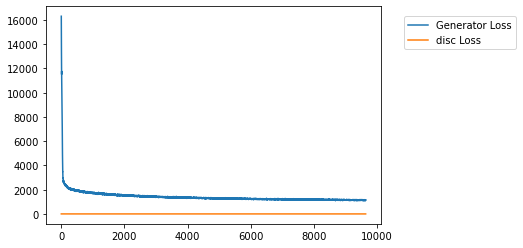

In [24]:
n_epochs=250
for epoch in tqdm(range(200,n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
                

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 254: Step 196605: Generator (U-Net) loss: 1136.6109735352818, Discriminator loss: 0.0002702756005433661

Saving Fake-images-epoch0254_step196605.png

Saving Real-images-epoch0254_step196605.png

Saving condition-images-epoch0254_step196605.png


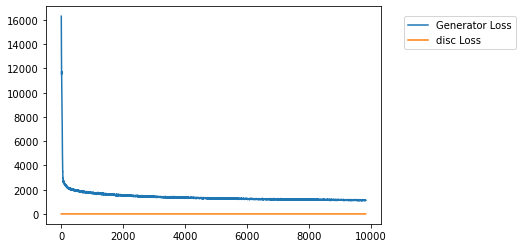

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 259: Step 200460: Generator (U-Net) loss: 1130.001840775978, Discriminator loss: 0.005050271070318733

Saving Fake-images-epoch0259_step200460.png

Saving Real-images-epoch0259_step200460.png

Saving condition-images-epoch0259_step200460.png


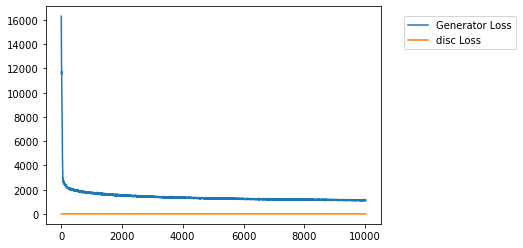

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 264: Step 204315: Generator (U-Net) loss: 1127.1898292313938, Discriminator loss: 0.0012031081506695266

Saving Fake-images-epoch0264_step204315.png

Saving Real-images-epoch0264_step204315.png

Saving condition-images-epoch0264_step204315.png


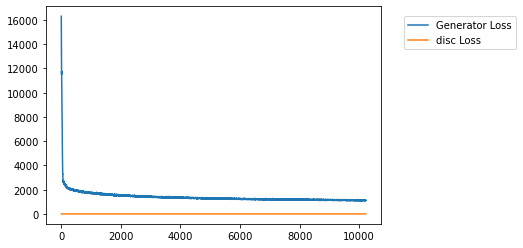

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 269: Step 208170: Generator (U-Net) loss: 1124.9192889459703, Discriminator loss: 0.003783208340263055

Saving Fake-images-epoch0269_step208170.png

Saving Real-images-epoch0269_step208170.png

Saving condition-images-epoch0269_step208170.png


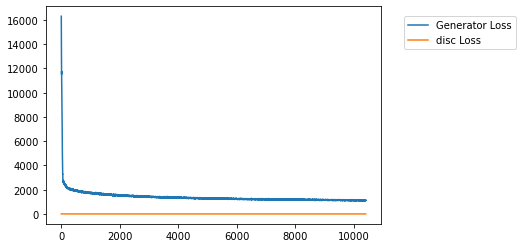

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 274: Step 212025: Generator (U-Net) loss: 1119.8105159061913, Discriminator loss: 1.0696317830048693e-05

Saving Fake-images-epoch0274_step212025.png

Saving Real-images-epoch0274_step212025.png

Saving condition-images-epoch0274_step212025.png


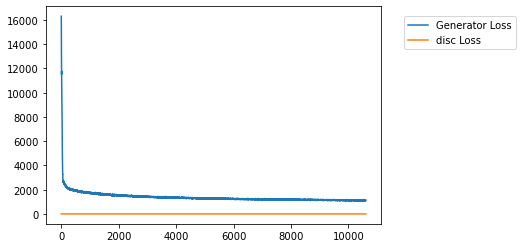

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 279: Step 215880: Generator (U-Net) loss: 1118.17024213937, Discriminator loss: 1.5404493589393085e-06

Saving Fake-images-epoch0279_step215880.png

Saving Real-images-epoch0279_step215880.png

Saving condition-images-epoch0279_step215880.png


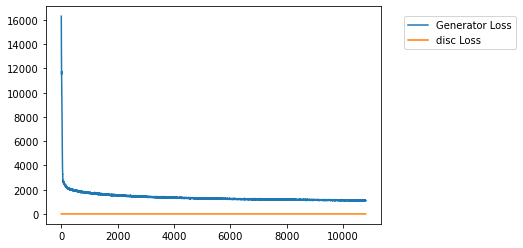

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 284: Step 219735: Generator (U-Net) loss: 1111.891852812019, Discriminator loss: 0.001907701467777753

Saving Fake-images-epoch0284_step219735.png

Saving Real-images-epoch0284_step219735.png

Saving condition-images-epoch0284_step219735.png


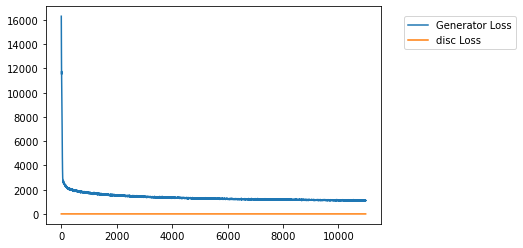

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 289: Step 223590: Generator (U-Net) loss: 1111.509793759753, Discriminator loss: 2.6563008198485727e-05

Saving Fake-images-epoch0289_step223590.png

Saving Real-images-epoch0289_step223590.png

Saving condition-images-epoch0289_step223590.png


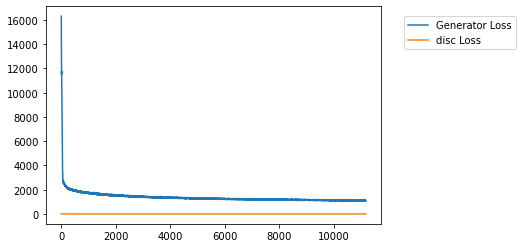

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 294: Step 227445: Generator (U-Net) loss: 1106.4553001789725, Discriminator loss: 0.00220052252977969

Saving Fake-images-epoch0294_step227445.png

Saving Real-images-epoch0294_step227445.png

Saving condition-images-epoch0294_step227445.png


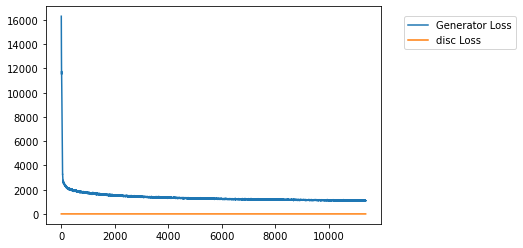

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 299: Step 231300: Generator (U-Net) loss: 1103.8295359174879, Discriminator loss: 0.000720207000051817

Saving Fake-images-epoch0299_step231300.png

Saving Real-images-epoch0299_step231300.png

Saving condition-images-epoch0299_step231300.png


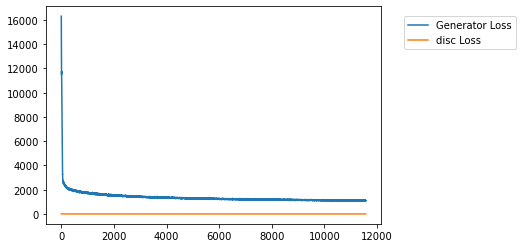

In [26]:
n_epochs=300
for epoch in tqdm(range(250,n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
               

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 304: Step 235155: Generator (U-Net) loss: 1097.5468898036004, Discriminator loss: 4.40996153644874e-06

Saving Fake-images-epoch0304_step235155.png

Saving Real-images-epoch0304_step235155.png

Saving condition-images-epoch0304_step235155.png


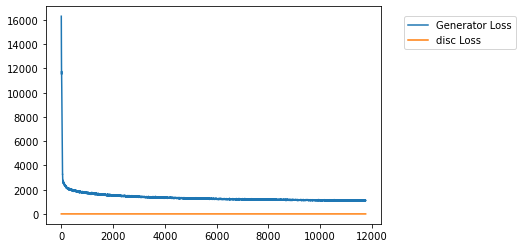

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 309: Step 239010: Generator (U-Net) loss: 1095.8088242428175, Discriminator loss: 0.005933322762211417

Saving Fake-images-epoch0309_step239010.png

Saving Real-images-epoch0309_step239010.png

Saving condition-images-epoch0309_step239010.png


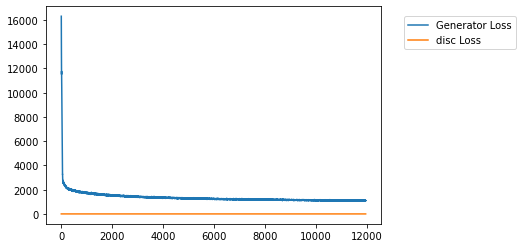

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 314: Step 242865: Generator (U-Net) loss: 1092.8679839652496, Discriminator loss: 0.0032754872249840584

Saving Fake-images-epoch0314_step242865.png

Saving Real-images-epoch0314_step242865.png

Saving condition-images-epoch0314_step242865.png


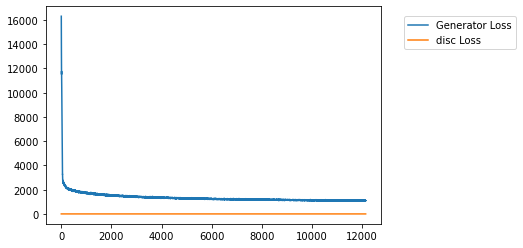

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 319: Step 246720: Generator (U-Net) loss: 1090.9384659229113, Discriminator loss: 6.68682395357128e-06

Saving Fake-images-epoch0319_step246720.png

Saving Real-images-epoch0319_step246720.png

Saving condition-images-epoch0319_step246720.png


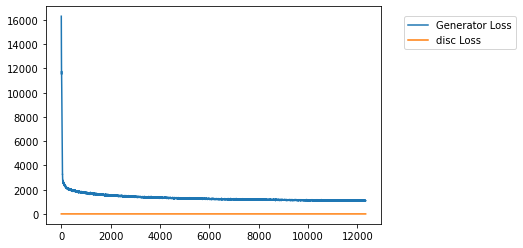

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 324: Step 250575: Generator (U-Net) loss: 1087.226621556067, Discriminator loss: 1.5654657527891378e-06

Saving Fake-images-epoch0324_step250575.png

Saving Real-images-epoch0324_step250575.png

Saving condition-images-epoch0324_step250575.png


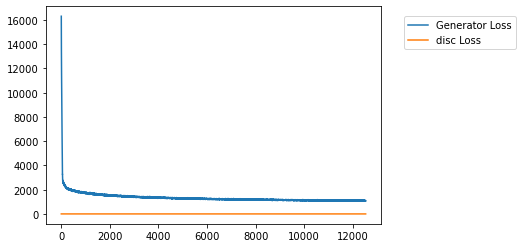

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 329: Step 254430: Generator (U-Net) loss: 1084.5543621533243, Discriminator loss: 0.0033382877958495413

Saving Fake-images-epoch0329_step254430.png

Saving Real-images-epoch0329_step254430.png

Saving condition-images-epoch0329_step254430.png


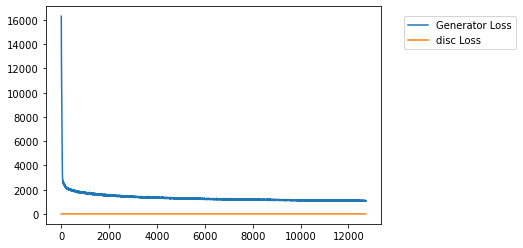

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 334: Step 258285: Generator (U-Net) loss: 1082.2919853160952, Discriminator loss: 0.0009106736292385257

Saving Fake-images-epoch0334_step258285.png

Saving Real-images-epoch0334_step258285.png

Saving condition-images-epoch0334_step258285.png


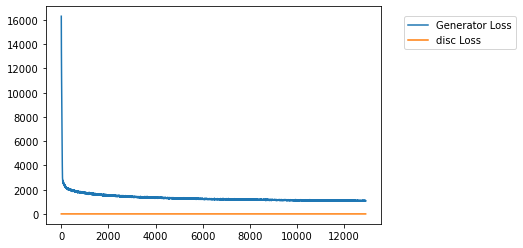

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 339: Step 262140: Generator (U-Net) loss: 1078.125602910182, Discriminator loss: 0.0029238694962946212

Saving Fake-images-epoch0339_step262140.png

Saving Real-images-epoch0339_step262140.png

Saving condition-images-epoch0339_step262140.png


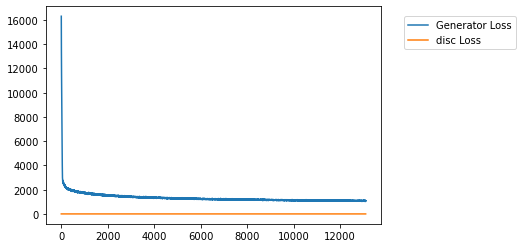

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 344: Step 265995: Generator (U-Net) loss: 1076.9348365714416, Discriminator loss: 0.0014298945396369219

Saving Fake-images-epoch0344_step265995.png

Saving Real-images-epoch0344_step265995.png

Saving condition-images-epoch0344_step265995.png


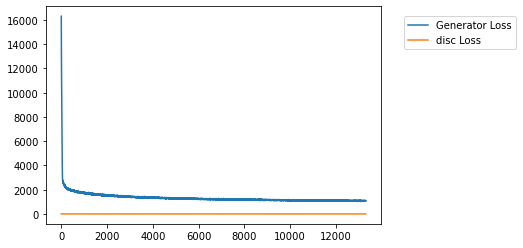

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 349: Step 269850: Generator (U-Net) loss: 1075.7844785143552, Discriminator loss: 5.075692940466123e-05

Saving Fake-images-epoch0349_step269850.png

Saving Real-images-epoch0349_step269850.png

Saving condition-images-epoch0349_step269850.png


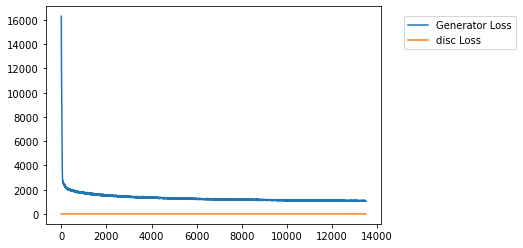

In [28]:
n_epochs=350
for epoch in tqdm(range(300,n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
               

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 354: Step 273705: Generator (U-Net) loss: 1071.9132465921623, Discriminator loss: 0.001253140322916011

Saving Fake-images-epoch0354_step273705.png

Saving Real-images-epoch0354_step273705.png

Saving condition-images-epoch0354_step273705.png


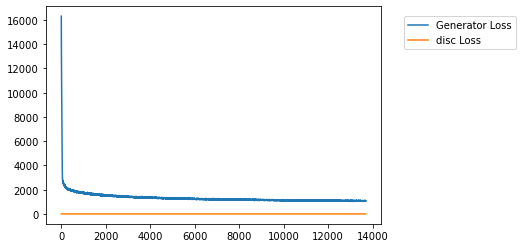

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 359: Step 277560: Generator (U-Net) loss: 1070.0084449698818, Discriminator loss: 0.0029859796874149363

Saving Fake-images-epoch0359_step277560.png

Saving Real-images-epoch0359_step277560.png

Saving condition-images-epoch0359_step277560.png


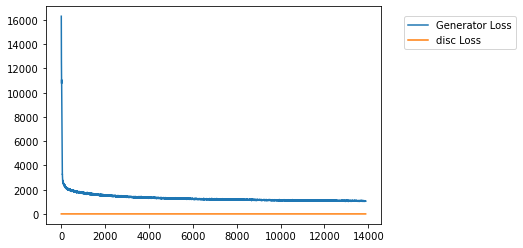

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 364: Step 281415: Generator (U-Net) loss: 1067.2204396526188, Discriminator loss: 1.4388048674183357e-05

Saving Fake-images-epoch0364_step281415.png

Saving Real-images-epoch0364_step281415.png

Saving condition-images-epoch0364_step281415.png


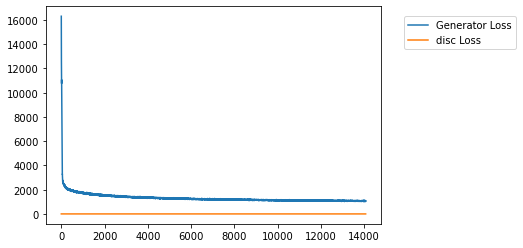

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 369: Step 285270: Generator (U-Net) loss: 1066.0824751046227, Discriminator loss: 1.6336108694812302e-06

Saving Fake-images-epoch0369_step285270.png

Saving Real-images-epoch0369_step285270.png

Saving condition-images-epoch0369_step285270.png


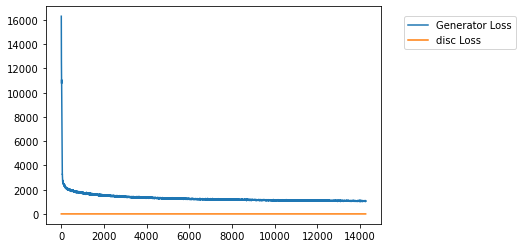

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 374: Step 289125: Generator (U-Net) loss: 1060.4811930021879, Discriminator loss: 0.0048106236634813

Saving Fake-images-epoch0374_step289125.png

Saving Real-images-epoch0374_step289125.png

Saving condition-images-epoch0374_step289125.png


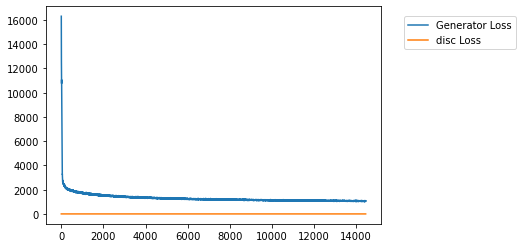

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 379: Step 292980: Generator (U-Net) loss: 1059.2246807964223, Discriminator loss: 5.152978997490938e-05

Saving Fake-images-epoch0379_step292980.png

Saving Real-images-epoch0379_step292980.png

Saving condition-images-epoch0379_step292980.png


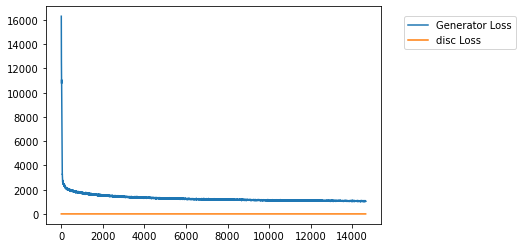

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 384: Step 296835: Generator (U-Net) loss: 1057.3255655766202, Discriminator loss: 0.0012436442839473566

Saving Fake-images-epoch0384_step296835.png

Saving Real-images-epoch0384_step296835.png

Saving condition-images-epoch0384_step296835.png


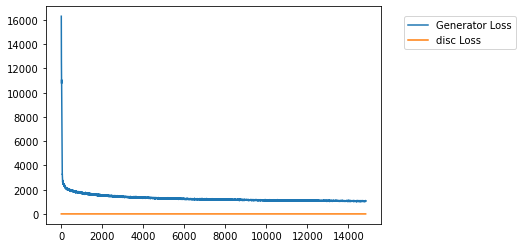

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 389: Step 300690: Generator (U-Net) loss: 1058.5586727711318, Discriminator loss: 7.895104469726562e-06

Saving Fake-images-epoch0389_step300690.png

Saving Real-images-epoch0389_step300690.png

Saving condition-images-epoch0389_step300690.png


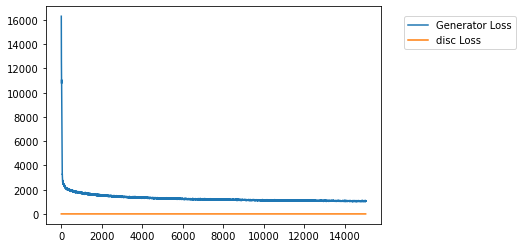

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 394: Step 304545: Generator (U-Net) loss: 1053.7371967716451, Discriminator loss: 0.00035773685896193976

Saving Fake-images-epoch0394_step304545.png

Saving Real-images-epoch0394_step304545.png

Saving condition-images-epoch0394_step304545.png


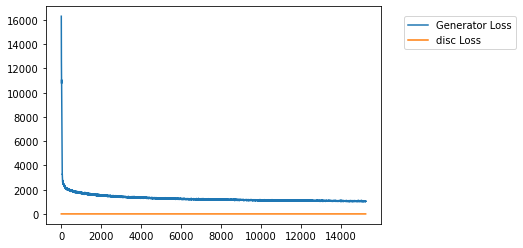

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

Epoch 399: Step 308400: Generator (U-Net) loss: 1052.238841554318, Discriminator loss: 0.002201756505395398

Saving Fake-images-epoch0399_step308400.png

Saving Real-images-epoch0399_step308400.png

Saving condition-images-epoch0399_step308400.png


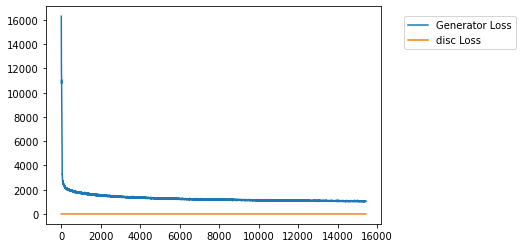

In [30]:
n_epochs=400
for epoch in tqdm(range(350,n_epochs)):
    # Dataloader returns the batches
    for image in tqdm(dataloader):

        noiseArr = getNoise()
        random.shuffle(noiseArr)
        real = image.reshape(batch_size,1,image_size,image_size).to(dtype=torch.float32)
        condition = real*noiseArr      
        #cur_batch_size = len(condition)
        condition = condition.to(device)
        real = real.to(device)
            #print(condition.shape)
            ### Update discriminator ###
        disc_opt.zero_grad() # Zero out the gradient before backpropagation
        with torch.no_grad():
            fake = gen(condition)
        disc_fake_hat = disc(fake.detach(), condition) # Detach generator
        disc_fake_loss = adv_criterion(disc_fake_hat, torch.zeros_like(disc_fake_hat))
        disc_real_hat = disc(real, condition)
        disc_real_loss = adv_criterion(disc_real_hat, torch.ones_like(disc_real_hat))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True) # Update gradients
        disc_opt.step() # Update optimizer
        ### Update generator ###
        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, real, condition, adv_criterion, recon_criterion, lambda_recon,noiseArr)
        gen_loss.backward() # Update gradients
        gen_opt.step() # Update optimizer

            # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
            # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step
        
        generator_losses += [gen_loss.item()]
        disc_losses += [disc_loss.item()]
            ### Visualization code ###
        cur_step += 1
        #if cur_step% display_step==0:
    if  (epoch+1)% 5 == 0:
        print(f"Epoch {epoch}: Step {cur_step}: Generator (U-Net) loss: {mean_generator_loss}, Discriminator loss: {mean_discriminator_loss}")
        show_tensor_images(epoch,cur_step,fake,RealOrFake=False)
        show_tensor_images(epoch,cur_step,real,RealOrFake=True)
        show_tensor_images(epoch,cur_step,condition,cond=True)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
        num_examples = (len(generator_losses) // step_bins) * step_bins

        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
                )
        plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(disc_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="disc Loss"
                    )

                        #plt.legend()
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", borderaxespad=1)
        plt.show()
        torch.save({'gen': gen.state_dict(),
                    'gen_opt': gen_opt.state_dict(),
                    'disc': disc.state_dict(),
                    'disc_opt': disc_opt.state_dict()
                }, f"/home/mena/G2BigGPU/128/5T30AllDataSet_Last/pix2pix_{cur_step}_epoch_{epoch+1}.pth")
               